<a href="https://colab.research.google.com/github/jmcnaughton67/health_in_film_research_paper/blob/main/Popcorn%20and%20Pathogens%20-%20Data%20analysis%20and%20Topic%20Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Configure Libraries

# Code to import and pre-process web scrape data of IMDB movie plots.
* Analyse them for health references and relevant visualisations.
* Analyse them for sentimental analysis and relevant visualisations.
* Analyse them for key topics using topic modelling and relevant visualisations.

In [ ]:
# Install Packages
pip install bertopic
pip install matplotlib
pip install pymannkendall

In [ ]:
# Import Libraries
from bs4 import BeautifulSoup
import json
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from lxml import html
import json
import csv
import openpyxl
import matplotlib.pyplot as plt
from textblob import TextBlob
from collections import defaultdict
import numpy as np
from scipy.stats import linregress
import pymannkendall as mk

## Pre-Processing
*   Convert year to integer
*   Upload csv to dataframe
*   Remove any empty values and print out count
*   Remove any films where the synopsis is less than 300 characters
*   Remove any movies where the title and year are the same and print out count
*   Remove any entries where the snyopsis is the same as antoher film in time

In [ ]:
# Convert Year to Integer

def convert_year_to_int(year):
    try:
        return int(float(year.rstrip('0').rstrip('.'))) # Convert year to int after stripping unnecessary characters

    except ValueError:
        return None # Handle the case where year is not a number

def update_csv(file_path):
    # Read the data and perform the update
    with open(file_path, 'r', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        # Store the updated rows in a new list
        updated_rows = []
        for row in reader:
            row['Year'] = convert_year_to_int(row['Year'])
            updated_rows.append(row)

    # Open the file again in write mode and overwrite the data
    with open(file_path, 'w', newline='') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=reader.fieldnames)
        writer.writeheader()
        writer.writerows(updated_rows)


csv_file_path = 'combined_data.csv'
update_csv(csv_file_path)


In [ ]:
# Read CSV of Inital Dataset
df = pd.read_csv('combined_data.csv', engine='python', encoding='utf-8', on_bad_lines='skip')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63000 entries, 0 to 62999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      63000 non-null  object
 1   Year       63000 non-null  int64 
 2   Movie URL  63000 non-null  object
 3   Synopsis   60047 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.9+ MB


In [ ]:
# Check how many each year following a filter for > 300 characters
# Filter the DataFrame to find rows where the 'Synopsis' has more than 300 characters
df = df[(df['Year'] >= 1960) & (df['Year'] <= 2022)]
long_synopses = df[df['Synopsis'].str.len() > 300]

#  Group by 'Year' and count the number of entries in each group
yearly_counts = long_synopses.groupby('Year').size()

# 4. Print the results to validate still sufficient data in dataset
print("Number of entries with a synopsis longer than 300 characters for each year (1960-2022):")
print(yearly_counts)

Number of entries with a synopsis longer than 300 characters for each year (1960-2022):
Year
1961    487
1962    496
1963    493
1964    512
1965    502
1966    553
1967    556
1968    563
1969    570
1971    622
1972    574
1973    577
1974    608
1975    563
1976    582
1977    559
1978    535
1979    557
1981    604
1982    577
1983    562
1984    591
1985    621
1986    626
1987    662
1988    680
1989    674
1991    660
1992    641
1993    682
1994    704
1995    718
1996    735
1997    740
1998    765
1999    766
2001    782
2002    826
2003    811
2004    831
2005    838
2006    862
2007    871
2008    880
2009    856
2011    813
2012    821
2013    841
2014    813
2015    830
2016    796
2017    789
2018    754
2019    769
2021    668
2022    617
dtype: int64


In [ ]:
# Filter the DataFrame to only include rows where the 'Synopsis' has more than 300 characters
df = df[df['Synopsis'].str.len() > 300]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37985 entries, 0 to 62997
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Title      37985 non-null  object
 1   Year       37985 non-null  int64 
 2   Movie URL  37985 non-null  object
 3   Synopsis   37985 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB


In [ ]:
# Remove entries where 'Synopsis' column is NaN
plot_is_nan_count = df['Synopsis'].isna().sum()
print(f"Number of rows where 'Synopsis' column is NaN: {plot_is_nan_count}")

# Filter out rows where 'Synopsis' column is NaN
df = df[df['Synopsis'].notna()]

# Remove rows where all columns are NaN
df = df.dropna(how='all')

# Reset the index after dropping rows, if necessary
df = df.reset_index(drop=True)

# Print the number of remaining rows
print(f"Total number of remaining rows: {len(df)}")


Number of rows where 'Synopsis' column is NaN: 0
Total number of remaining rows: 37985
Number of rows in remaining 'Synopsis' column: 37985


In [ ]:
# Find any movies with title and synopsis are the same
same_title_plot = df[df.apply(lambda x: x['Title'] == x['Synopsis'], axis=1)]
print(f"Number of movies where title and plot are the same: {same_title_plot.shape[0]}")
same_title_plot.head(5)

Number of movies where title and plot are the same: 0


,Title,Year,Movie URL,Synopsis


In [ ]:
# Remove any movies with synopsis and title the same
df = df[df.apply(lambda x: x['title'] != x['plot'], axis=1)]

# Reference Analysis
* Set up Key Term List for sub-groups
* Count key terms by no. of references by year
* Count movies with health references by year
* Find Top 10 Films with most health references and Top Topics with most references/films


In [ ]:
workbook = openpyxl.load_workbook('topic_terms.xlsx')
worksheet = workbook.active

# SETTING UP KEY TERMS
print('Setting up key terms...')
# Create an empty dictionary to store the key term groups
key_term_groups = {}

# Loop through each column in the worksheet
for column in worksheet.iter_cols():
    # Get the name of the key term group from the first cell in the column
    group_name = column[0].value

    # Create a list to store the key terms for the current group
    key_terms = []

    # Loop through each cell in the column (starting from the second cell)
    for cell in column[1:]:
        # If the cell is not empty, add its value to the list of key terms for the current group
        if cell.value:
            key_terms.append(cell.value)

    # Add the current group to the dictionary of key term groups
    key_term_groups[group_name] = key_terms
    print(f'Added {group_name} to key term groups')

# Convert key terms to lowercase
for group_name, key_terms in key_term_groups.items():
    key_term_groups[group_name] = [key_term.lower() for key_term in key_terms]

# Print the key term groups
for group_name, key_terms in key_term_groups.items():
    print(group_name, ':', key_terms)


Setting up key terms...
Added Nutrition to key term groups
Added Mental Health to key term groups
Added Reproductive Health to key term groups
Added Global Health to key term groups
Added Addiction to key term groups
Added Health Science to key term groups
Added Biotechnology to key term groups
Added Aging and Geriatrics to key term groups
Added Genetics to key term groups
Added Cancer to key term groups
Added Oral Health to key term groups
Added Eye  to key term groups
Added Surgical to key term groups
Added Neurological  to key term groups
Added Digestive  to key term groups
Added Bone and Joint to key term groups
Added Cardiovascular to key term groups
Added Respiratory to key term groups
Nutrition : ['nutrition', 'macronutrient', 'micronutrient', 'carbohydrate', 'protein', 'fat', 'vitamin', 'mineral', 'fiber', 'calorie', 'amino acid', 'saturated fat', 'unsaturated fat', 'trans fat', 'cholesterol', 'glycemic index', 'electrolyte', 'antioxidant', 'phytochemical', 'probiotic', 'prebio

In [ ]:
# COUNTING KEY TERMS - TOTAL COUNT OF REFERENCES

print('Counting key terms...')
year_counts = {}

# Get the unique years present in the DataFrame
unique_years = df['Year'].unique()

for year in unique_years:
    print('Checking year:', year)

    # Filter the DataFrame for each year
    yearly_data = df[df['Year'] == year]

    print('Number of Films in this year:', len(yearly_data))

    # Initialize a new entry in the year_counts dictionary for the year
    if year not in year_counts:
        year_counts[year] = {}

    for index, row in yearly_data.iterrows():
        plot = row['Synopsis']
        words = plot.split()

        # Loop through each key term group
        for group_name, key_terms in key_term_groups.items():
            group_count = 0

            for word in words:
                # If the word is a key term in the current group, increment the count for the group
                if word.lower() in key_terms:
                    group_count += 1
                    print(f'Found {word} in {group_name} in the film {row["Title"]}')

            # If the current group has at least one key term in the plot text, increment the count for the corresponding year in the dictionary
            if group_count > 0:
                if group_name not in year_counts[year]:
                    year_counts[year][group_name] = 0

                # Now update the count
                year_counts[year][group_name] += group_count

# Print the final count of key terms by year and by group
for year, groups in year_counts.items():
    print(f'Year: {year}')
    for group, count in groups.items():
        print(f'\t{group}: {count}')

print('Writing results to csv file...')

# Write the count of key term groups for each year to a csv file
with open('topic_counts_by_year.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    # Write the header row
    headers = ['Year'] + list(key_term_groups.keys())
    writer.writerow(headers)
    # Write the data rows
    for year, group_counts in sorted(year_counts.items()):
        row = [year] + [group_counts.get(group_name, 0) for group_name in key_term_groups.keys()]
        writer.writerow(row)

print('Results written to topic_counts_by_year.csv')

In [ ]:
# Films with Health References over Time

print('Counting films with health references...')
year_counts = {}

# Get the unique years present in the DataFrame
unique_years = df['Year'].unique()

total_films_with_health_refs = 0

for year in unique_years:
    print('Checking year:', year)

    # Filter the DataFrame for each year
    yearly_data = df[df['Year'] == year]

    print('Number of Films in this year:', len(yearly_data))

    films_with_health_refs = 0

    for index, row in yearly_data.iterrows():
        plot = str(row['Synopsis']).lower()
        words = set(plot.split())  # Using a set to ensure each word is only counted once per film

        found_health_term = False

        for group_name, key_terms in key_term_groups.items():
            if found_health_term:
                break  # If a health term has already been found, no need to continue checking

            for word in words:
                if word in key_terms:
                    found_health_term = True
                    films_with_health_refs += 1
                    total_films_with_health_refs += 1
                    print(f'Found {word} in {group_name} in the film {row["Title"]}')
                    break

    year_counts[year] = films_with_health_refs


In [ ]:
# Find Top Films and Top Topics

# Initialize dictionaries to store results
term_films = {}
film_term_counts = {}

# Loop through each row in the DataFrame
for index, row in df.iterrows():
    plot = str(row['Synopsis']).lower()
    words = set(plot.split())  # using set to ensure unique words in a single synopsis
    film_count = 0

    for group_name, key_terms in key_term_groups.items():
        for word in words:
            # If the word is a key term in any group
            if word in key_terms:
                film_count += 1

                # Update the film list for the term
                if word not in term_films:
                    term_films[word] = set()
                term_films[word].add(row['Title'])

    # Update the film's term count
    film_term_counts[row['Title']] = film_count

# Calculating the number of films each term appears in
term_film_counts = {term: len(films) for term, films in term_films.items()}

# Sorting the terms by the number of films they appear in
sorted_terms = sorted(term_film_counts.items(), key=lambda x: x[1], reverse=True)

# Sorting the films by their term counts
sorted_films = sorted(film_term_counts.items(), key=lambda x: x[1], reverse=True)

# Printing results
print("Terms appearing in the most films:")
for term, count in sorted_terms[:10]:  # Printing top 10 terms for illustration
    print(f"{term}: {count} films")

print("\nFilms with the most terms in their synopses:")
for film, count in sorted_films[:10]:  # Printing top 10 films for illustration
    print(f"{film}: {count} terms")


Terms appearing in the most films:
heart: 1957 films
suicide: 1208 films
behavior: 718 films
alcoholic: 545 films
obsession: 397 films
crisis: 382 films
alcohol: 349 films
iron: 332 films
psychiatrist: 332 films
retirement: 277 films

Films with the most terms in their synopses:
20th Century Women: 15 terms
The Tournament: 14 terms
Beautiful Boy: 13 terms
Nymphomaniac: Vol. II: 13 terms
Shangri-La Suite: 13 terms
Valley of the Dolls: 12 terms
The Girl on the Train: 11 terms
Forbidden World: 11 terms
Crimes of the Future: 10 terms
Shine: 10 terms


# Visualisations - Reference Analysis


*   Print out of no. of movies referending health terms
*   Print out of no. of health term references in movies
*   Line Chart - Health References over Time
*   List item - Movies with health references over Time


In [ ]:
# Get Counts for Movies with Health Terms and Health Term References
# Initialize variables to store the total count of health references and number of movies with health references
total_health_references = 0
movies_with_health_references = 0
movies_checked = set()

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    plot = str(row['Synopsis']).lower()
    movie_id = row['Title'] + str(row['Year'])  # Creating a unique identifier for each movie'
    print(movie_id)

    health_refs_in_movie = 0
    # Check and count the health terms present in the plot
    for group_name, key_terms in key_term_groups.items():
        for key_term in key_terms:
            count = plot.split().count(key_term)
            if count > 0:
                health_refs_in_movie += count

    if health_refs_in_movie > 0:
        total_health_references += health_refs_in_movie
        if movie_id not in movies_checked:
            movies_with_health_references += 1
            movies_checked.add(movie_id)

# Print the results
print(f'Movies referencing health terms = {movies_with_health_references}')
print(f'Health Terms referenced in movies = {total_health_references}')


In [ ]:
# Initialize a dictionary to store the count of films with health references by year
films_with_health_refs_count = {}
total_films_by_year = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    year = int(row['Year'])
    plot = str(row['Synopsis']).lower()

    # Update the total films count for the year
    if year in total_films_by_year:
        total_films_by_year[year] += 1
    else:
        total_films_by_year[year] = 1

    # Check if any health term is present in the plot
    if year not in films_with_health_refs_count:
        films_with_health_refs_count[year] = 0

    for group_name, key_terms in key_term_groups.items():
        if any(key_term in plot for key_term in key_terms):
            films_with_health_refs_count[year] += 1
            break


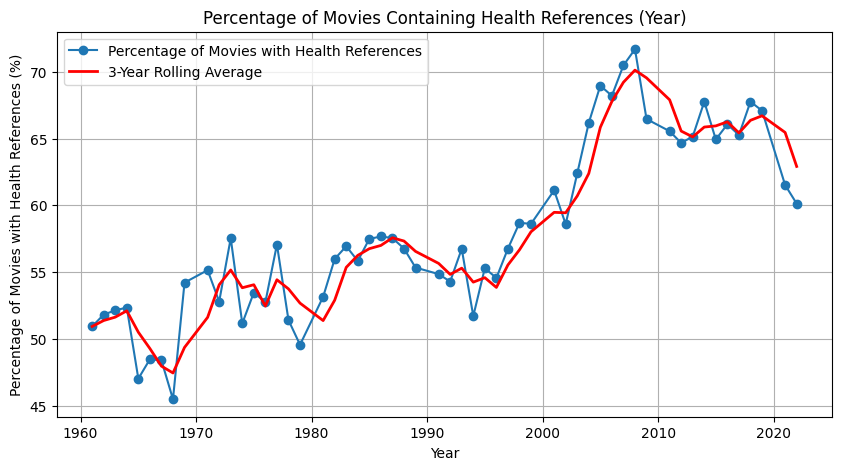

In [ ]:
# Visualisation for Percentage of Movies Containing Health References by Year
# Calculate the percentage of films with health references for each year
percentage_films_with_health_refs = {year: (films_with_health_refs_count[year] / total_films_by_year[year]) * 100 for year in total_films_by_year.keys()}

# Convert the data to a pandas DataFrame
data = {'Year': sorted(percentage_films_with_health_refs.keys()),
        'Percentage of Movies with Health References': [percentage_films_with_health_refs[year] for year in sorted(percentage_films_with_health_refs.keys())]}
percentage_df = pd.DataFrame(data)

# Set the Year column as the DataFrame index
percentage_df.set_index('Year', inplace=True)

# Calculate the 3-year rolling average
percentage_df['3Y Rolling Avg'] = percentage_df['Percentage of Movies with Health References'].rolling(window=3, min_periods=1).mean()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(percentage_df.index, percentage_df['Percentage of Movies with Health References'], marker='o', label='Percentage of Movies with Health References')
plt.plot(percentage_df.index, percentage_df['3Y Rolling Avg'], marker='', linestyle='-', linewidth=2, color='red', label='3-Year Rolling Average')

# Adding title and labels
plt.title('Percentage of Movies Containing Health References (Year)')
plt.xlabel('Year')
plt.ylabel('Percentage of Movies with Health References (%)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [ ]:
# Set up for Total Health References per Year

# Initialize a dictionary to store the total health references count by year
total_health_refs_by_year = {}

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    year = int(row['Year'])
    plot = str(row['Synopsis']).lower()

    # Initialize the count for the year if not already done
    if year not in total_health_refs_by_year:
        total_health_refs_by_year[year] = 0

    # Check and count the health terms present in the plot
    for group_name, key_terms in key_term_groups.items():
        for key_term in key_terms:
            total_health_refs_by_year[year] += plot.split().count(key_term)


In [ ]:
# Visualisation for Total Health References by Year

# Convert the data to a pandas DataFrame
data = {'Year': sorted(total_health_refs_by_year.keys()),
        'Total Health References': [total_health_refs_by_year[year] for year in sorted(total_health_refs_by_year.keys())]}
thr_df = pd.DataFrame(data)

# Set the Year column as the DataFrame index
thr_df.set_index('Year', inplace=True)

# Calculate the 3-year rolling average
thr_df['3Y Rolling Avg'] = thr_df['Total Health References'].rolling(window=3, min_periods=1).mean()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(thr_df.index, thr_df['Total Health References'], marker='o', label='Total Health References')
plt.plot(thr_df.index, thr_df['3Y Rolling Avg'], marker='', linestyle='-', linewidth=2, color='red', label='3-Year Rolling Average')

# Adding title and labels
plt.title('Total Health References in Movies by Year')
plt.xlabel('Year')
plt.ylabel('Total Health References')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


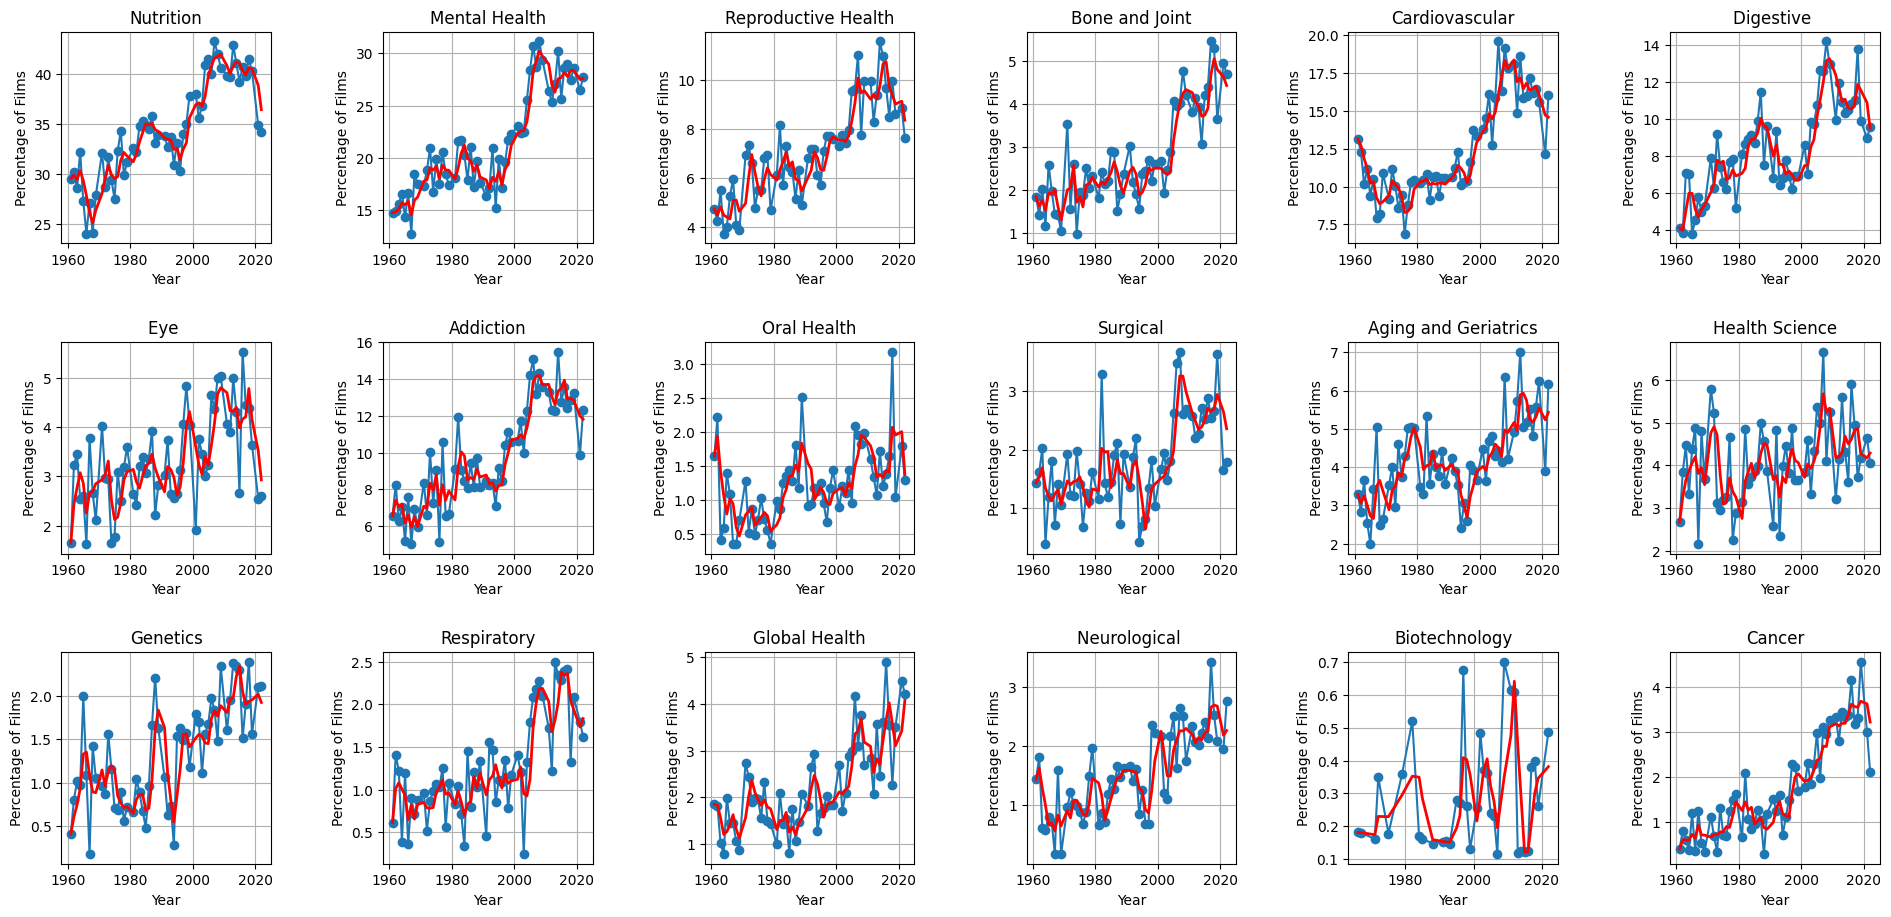

In [ ]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

# Initialize a dictionary to store the count of films referencing each sub-group term by year
films_with_subgroup_refs_count = defaultdict(lambda: defaultdict(int))
total_films_by_year = defaultdict(int)

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    year = int(row['Year'])
    plot = str(row['Synopsis']).lower()

    # Update the total films count for the year
    total_films_by_year[year] += 1

    # Check if any term from each sub-group is present in the plot
    for group_name, key_terms in key_term_groups.items():
        for key_term in key_terms:
            if key_term in plot:
                films_with_subgroup_refs_count[group_name][year] += 1
                break

# Convert the counts to percentages
films_with_subgroup_refs_percentage = {
    subgroup: {year: (count / total_films_by_year[year]) * 100
               for year, count in yearly_counts.items()}
    for subgroup, yearly_counts in films_with_subgroup_refs_count.items()
}

# Now you can use this data to plot the results
fig, axs = plt.subplots(3, 6, figsize=(20, 10))
fig.tight_layout(pad=5.0)

subtopics = list(films_with_subgroup_refs_percentage.keys())
for i in range(3):
    for j in range(6):
        index = i * 6 + j
        if index >= len(subtopics):
            axs[i, j].axis('off')  # turn off axes for empty subplots
        else:
            subtopic = subtopics[index]
            yearly_percentages = films_with_subgroup_refs_percentage[subtopic]

            # Convert the dictionary to a pandas DataFrame
            percentage_df = pd.DataFrame(list(yearly_percentages.items()), columns=['Year', 'Percentage of Films'])

            # Sort the DataFrame based on Year
            percentage_df = percentage_df.sort_values(by='Year')

            # Set the Year column as the DataFrame index
            percentage_df.set_index('Year', inplace=True)

            # Calculate the 3-year rolling average
            percentage_df['3Y Rolling Avg'] = percentage_df['Percentage of Films'].rolling(window=3, min_periods=1).mean()

            # Plotting
            axs[i, j].plot(percentage_df.index, percentage_df['Percentage of Films'], marker='o', label='Percentage of Films')
            axs[i, j].plot(percentage_df.index, percentage_df['3Y Rolling Avg'], marker='', linestyle='-', linewidth=2, color='red', label='3-Year Rolling Average')
            axs[i, j].set_title(f'{subtopic}')
            axs[i, j].set_xlabel('Year')
            axs[i, j].set_ylabel('Percentage of Films')
            axs[i, j].grid(True)

plt.show()


# Sentimental Analysis
Generates the following:
- Average sentiment towards each sub-group by year
- Average sentiment of the whole year for all topic terms.
- Average sentiment towards each subtopic for all years
- Average sentiment towards all health terms across all years.
- Top 10 Postiive and Negative Terms

In [ ]:
!pip install textblob

In [ ]:
import csv
from textblob import TextBlob
import pandas as pd
from collections import defaultdict

def sentimental_analysis(text, term):
    term_indices = [i for i, e in enumerate(text.split()) if term in e]
    sentiment_scores = []

    for index in term_indices:
        words = text.split()
        start_index = max(0, index - 30)
        end_index = min(len(words), index + 30)
        context = ' '.join(words[start_index:end_index])
        analysis = TextBlob(context)
        sentiment_scores.append(analysis.sentiment.polarity)

    return sentiment_scores

# Initialization
total_yearly_sentiment = defaultdict(float)
total_yearly_counts = defaultdict(int)
subtopic_sentiment = defaultdict(float)
subtopic_counts = defaultdict(int)
term_sentiment = defaultdict(float)
term_counts = defaultdict(int)

# Process each row in the DataFrame
for index, row in df.iterrows():
    year = int(row['Year'])
    plot = row['Synopsis'].lower()

    # Process each key term group
    for subtopic, key_terms in key_term_groups.items():
        for key_term in key_terms:
            key_term = key_term.lower()  # ensure matching is case-insensitive
            if key_term in plot:
                sentiment_scores = sentimental_analysis(plot, key_term)
                total_sentiment = sum(sentiment_scores)
                count = len(sentiment_scores)

                total_yearly_sentiment[year] += total_sentiment
                total_yearly_counts[year] += count

                subtopic_sentiment[subtopic] += total_sentiment
                subtopic_counts[subtopic] += count

                term_sentiment[key_term] += total_sentiment
                term_counts[key_term] += count

# Calculate averages
average_yearly_sentiment = {year: sentiment/total_yearly_counts[year]
                            for year, sentiment in total_yearly_sentiment.items() if total_yearly_counts[year] != 0}

average_subtopic_sentiment = {subtopic: sentiment/subtopic_counts[subtopic]
                              for subtopic, sentiment in subtopic_sentiment.items() if subtopic_counts[subtopic] != 0}

average_term_sentiment = {term: sentiment/term_counts[term]
                          for term, sentiment in term_sentiment.items() if term_counts[term] != 0}

# Calculate the overall average sentiment for all terms across all years
overall_average_sentiment = sum(term_sentiment.values()) / sum(term_counts.values()) if term_counts.values() else 0

# Output to console
print('Average sentiment per year for all terms:', average_yearly_sentiment)
print('Average sentiment per subtopic across all years:', average_subtopic_sentiment)
print('Average sentiment for each term across all years:', average_term_sentiment)
print('Overall average sentiment for all terms across all years:', overall_average_sentiment)


Average sentiment per year for all terms: {2019: 0.030846997230160888, 2018: 0.029137056831903502, 2008: 0.049858386643073994, 2009: 0.03598673923765038, 2021: 0.01451882752598603, 2022: 0.030894763700302277, 1996: 0.03483309527559736, 1982: 0.029749401329796685, 1969: 0.059435431380885265, 1968: 0.04149934956237049, 1983: 0.03645980340095338, 1997: 0.030959127438678333, 1981: 0.03951176298348503, 1995: 0.03437091180934153, 1994: 0.03945951325307883, 1984: 0.014470173858812285, 1991: 0.03918693792110982, 1985: 0.03347456528167374, 1993: 0.02282383732856871, 1987: 0.0348278485435952, 1978: 0.04368763246959653, 1979: 0.021434861879833858, 1986: 0.036419195470591526, 1992: 0.02739042812539028, 1974: 0.02592720569415292, 1961: 0.06214915083807037, 1975: 0.03713780459151444, 1988: 0.03657658282716352, 1963: 0.04364290414099019, 1977: 0.02651265017243192, 1976: 0.02141502109486544, 1962: 0.05190206778784524, 1989: 0.029918548110555512, 1999: 0.03767407586895696, 1966: 0.047230929990544304, 1

In [ ]:
# Dictionaries to store total sentiment and counts for each subgroup
subgroup_total_sentiment = defaultdict(float)
subgroup_total_counts = defaultdict(int)

# Sum up sentiment scores and counts for each subgroup
for subtopic in average_subgroup_yearly_sentiment:
    for year in average_subgroup_yearly_sentiment[subtopic]:
        subgroup_total_sentiment[subtopic] += subgroup_yearly_sentiment[subtopic][year]
        subgroup_total_counts[subtopic] += subgroup_yearly_counts[subtopic][year]

# Compute average sentiment for each subgroup
average_subgroup_sentiment = {subtopic: sentiment / subgroup_total_counts[subtopic]
                              for subtopic, sentiment in subgroup_total_sentiment.items()
                              if subgroup_total_counts[subtopic] != 0}

# Display results
for subtopic, sentiment in average_subgroup_sentiment.items():
    print(f"{subtopic}: {sentiment:.3f}")


Nutrition: 0.039
Mental Health: 0.023
Reproductive Health: 0.034
Bone and Joint: 0.035
Cardiovascular: 0.070
Digestive : 0.034
Eye : 0.030
Addiction: 0.030
Oral Health: 0.039
Surgical: 0.034
Aging and Geriatrics: 0.040
Health Science: 0.037
Genetics: 0.039
Respiratory: 0.020
Global Health: 0.012
Neurological : 0.015
Biotechnology: 0.044
Cancer: 0.038


In [ ]:

# Sentiment Analysis Overview
def sentimental_analysis(text, term):
    term_indices = [i for i, e in enumerate(text.split()) if term in e]
    sentiment_scores = []
    for index in term_indices:
        words = text.split()
        start_index = max(0, index - 30)
        end_index = min(len(words), index + 30)
        context = ' '.join(words[start_index:end_index])
        analysis = TextBlob(context)
        sentiment_scores.append(analysis.sentiment.polarity)
    return sentiment_scores

# Dictionaries to store yearly sentiment totals and counts for each subgroup
subgroup_yearly_sentiment = defaultdict(lambda: defaultdict(float))
subgroup_yearly_counts = defaultdict(lambda: defaultdict(int))

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    year = int(row['Year'])
    plot = str(row['Synopsis']).lower()
    for subtopic, key_terms in key_term_groups.items():
        for key_term in key_terms:
            key_term = key_term.lower()
            if key_term in plot:
                sentiment_scores = sentimental_analysis(plot, key_term)
                total_sentiment = sum(sentiment_scores)
                count = len(sentiment_scores)
                subgroup_yearly_sentiment[subtopic][year] += total_sentiment
                subgroup_yearly_counts[subtopic][year] += count

# Compute average yearly sentiment for each subgroup
average_subgroup_yearly_sentiment = {
    subtopic: {year: sentiment/subgroup_yearly_counts[subtopic][year]
               for year, sentiment in yearly_sentiments.items() if subgroup_yearly_counts[subtopic][year] != 0}
    for subtopic, yearly_sentiments in subgroup_yearly_sentiment.items()
}

# Display results
for subtopic, yearly_sentiments in average_subgroup_yearly_sentiment.items():
    for year, sentiment in yearly_sentiments.items():
        print(f"{subtopic} {year} {sentiment:.2f}")


# Visualisations - Sentiment Analysis

In [ ]:
# FIND TOP 10 POSITIVE AND NEGATIVE REFERENCES

from textblob import TextBlob
from collections import defaultdict

def sentimental_analysis(text, term):
    term_indices = [i for i, e in enumerate(text.split()) if term in e]
    sentiment_scores = []

    for index in term_indices:
        words = text.split()
        start_index = max(0, index - 30)
        end_index = min(len(words), index + 30)
        context = ' '.join(words[start_index:end_index])
        analysis = TextBlob(context)
        sentiment_scores.append(analysis.sentiment.polarity)

    return sentiment_scores

# Dictionary to store cumulative sentiment values and counts for each term
term_sentiments = defaultdict(float)
term_counts = defaultdict(int)

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    plot = str(row['Synopsis']).lower()

    for key_terms in key_term_groups.values():
        for key_term in key_terms:
            key_term = key_term.lower()
            if key_term in plot:
                sentiment_scores = sentimental_analysis(plot, key_term)
                term_sentiments[key_term] += sum(sentiment_scores)
                term_counts[key_term] += len(sentiment_scores)

# Calculate average sentiment for each term
average_sentiments = {term: term_sentiments[term]/term_counts[term] for term in term_counts if term_counts[term] != 0}

# Extract top 10 and bottom 10 terms
sorted_terms = sorted(average_sentiments.items(), key=lambda kv: kv[1])
top_10_terms = sorted_terms[-10:]
bottom_10_terms = sorted_terms[:10]

print("Top 10 terms with the highest sentiment:")
for term, sentiment in reversed(top_10_terms):
    print(f"{term}: {sentiment:.2f}")

print("\nBottom 10 terms with the lowest sentiment:")
for term, sentiment in bottom_10_terms:
    print(f"{term}: {sentiment:.2f}")


Top 10 terms with the highest sentiment:
cerebrum: 0.67
fluoride: 0.60
echocardiogram: 0.33
pharmacology: 0.32
genomics: 0.32
mucus: 0.28
intron: 0.24
neuroscientist: 0.24
bunions: 0.24
enabler: 0.24

Bottom 10 terms with the lowest sentiment:
bacteriology: -0.48
incisor: -0.40
gastritis: -0.33
transgenic: -0.28
crispr: -0.25
capillaries: -0.24
diarrhea: -0.24
hernia: -0.22
respiration: -0.21
naloxone: -0.20


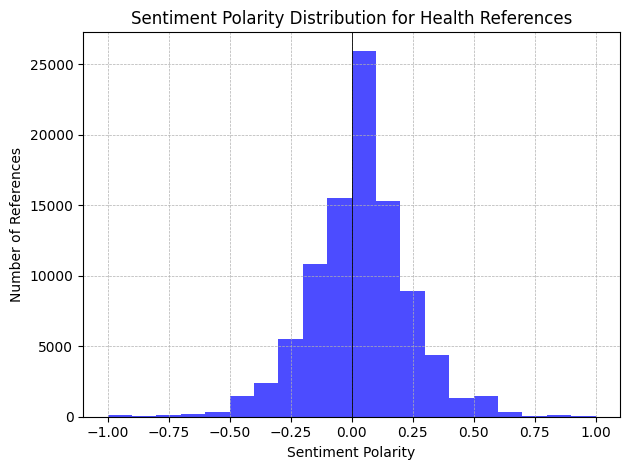

In [ ]:
# Histogram Plot

import matplotlib.pyplot as plt
from textblob import TextBlob
from collections import defaultdict

def sentimental_analysis(text, term):
    term_indices = [i for i, e in enumerate(text.split()) if term in e]
    sentiment_scores = []

    for index in term_indices:
        words = text.split()
        start_index = max(0, index - 30)
        end_index = min(len(words), index + 30)
        context = ' '.join(words[start_index:end_index])
        analysis = TextBlob(context)
        sentiment_scores.append(analysis.sentiment.polarity)

    return sentiment_scores

# List to store sentiment polarities for all health references
all_sentiments = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    plot = str(row['Synopsis']).lower()

    for key_terms in key_term_groups.values():
        for key_term in key_terms:
            key_term = key_term.lower()
            if key_term in plot:
                sentiment_scores = sentimental_analysis(plot, key_term)
                all_sentiments.extend(sentiment_scores)

# Plot histogram
plt.hist(all_sentiments, bins=20, range=[-1, 1], facecolor='blue', alpha=0.7)
plt.title('Sentiment Polarity Distribution for Health References')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Number of References')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.axhline(0, color='black',linewidth=0.6)
plt.axvline(0, color='black',linewidth=0.6)
plt.tight_layout()
plt.show()



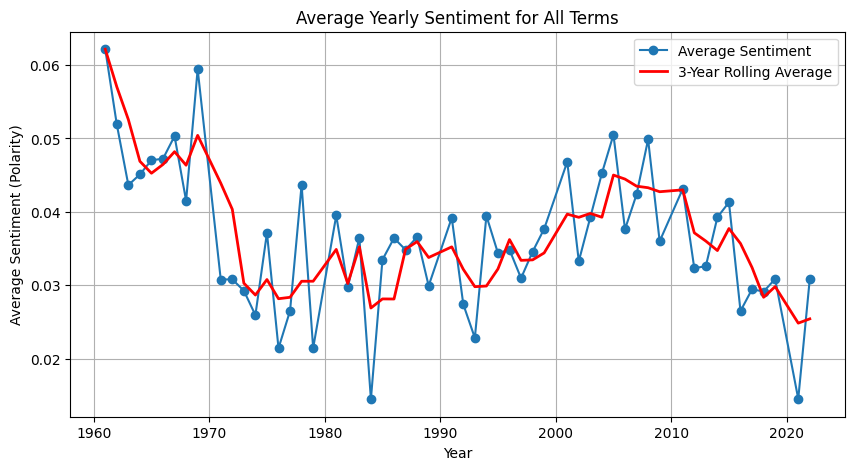

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Converting the data to a pandas DataFrame
data = {'Year': list(average_yearly_sentiment.keys()),
        'Average Sentiment': list(average_yearly_sentiment.values())}
sentiment_df = pd.DataFrame(data)

# Set the Year column as the DataFrame index
sentiment_df.set_index('Year', inplace=True)

# Calculate the 3-year rolling average
sentiment_df['3Y Rolling Avg'] = sentiment_df['Average Sentiment'].rolling(window=3, min_periods=1).mean()

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(sentiment_df.index, sentiment_df['Average Sentiment'], marker='o', label='Average Sentiment')
plt.plot(sentiment_df.index, sentiment_df['3Y Rolling Avg'], marker='', linestyle='-', linewidth=2, color='red', label='3-Year Rolling Average')

# Adding title and labels
plt.title('Average Yearly Sentiment for All Terms')
plt.xlabel('Year')
plt.ylabel('Average Sentiment (Polarity)')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


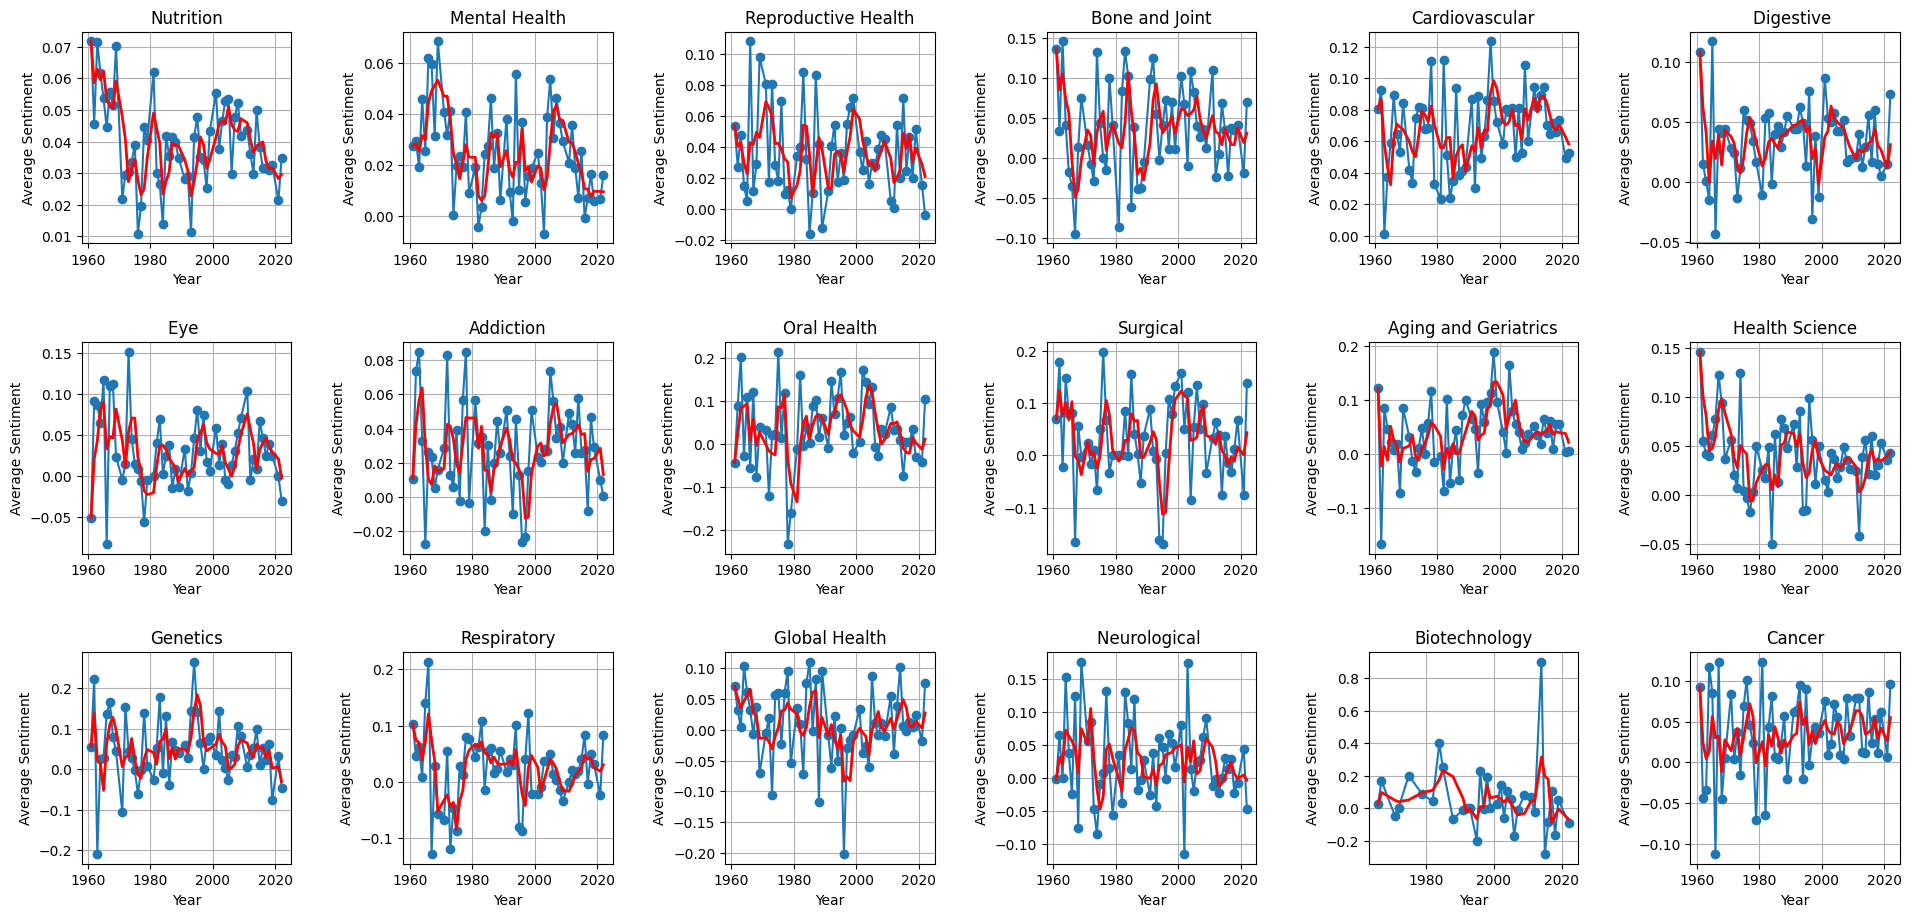

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 6, figsize=(20, 10))  # Adjusted the grid size here
fig.tight_layout(pad=5.0)

subtopics = list(average_subgroup_yearly_sentiment.keys())
for i in range(3):
    for j in range(6):
        index = i * 6 + j
        if index >= len(subtopics):
            axs[i, j].axis('off')  # turn off axes for empty subplots
        else:
            subtopic = subtopics[index]
            yearly_sentiments = average_subgroup_yearly_sentiment[subtopic]

            # Convert the dictionary to a pandas DataFrame
            rolling_df = pd.DataFrame(list(yearly_sentiments.items()), columns=['Year', 'Average Sentiment'])

            # Sort the DataFrame based on Year
            rolling_df = rolling_df.sort_values(by='Year')

            # Set the Year column as the DataFrame index
            rolling_df.set_index('Year', inplace=True)

            # Calculate the 3-year rolling average
            rolling_df['3Y Rolling Avg'] = rolling_df['Average Sentiment'].rolling(window=3, min_periods=1).mean()

            # Plotting
            axs[i, j].plot(rolling_df.index, rolling_df['Average Sentiment'], marker='o', label='Average Sentiment')
            axs[i, j].plot(rolling_df.index, rolling_df['3Y Rolling Avg'], marker='', linestyle='-', linewidth=2, color='red', label='3-Year Rolling Average')
            axs[i, j].set_title(f'{subtopic}')
            axs[i, j].set_xlabel('Year')
            axs[i, j].set_ylabel('Average Sentiment')
            axs[i, j].grid(True)

plt.show()


In [ ]:
# Function to perform sentimental analysis
def sentimental_analysis(text, term):
    term_indices = [i for i, e in enumerate(text.split()) if term in e]
    sentiment_scores = []

    for index in term_indices:
        words = text.split()
        start_index = max(0, index - 50)
        end_index = min(len(words), index + 50)
        context = ' '.join(words[start_index:end_index])
        analysis = TextBlob(context)
        sentiment_scores.append(analysis.sentiment.polarity)

    return sentiment_scores

# Set up for storing results
results_list = []

# Iterate over each row in the DataFrame
for index, row in df.iterrows():
    year = int(row['Year'])
    plot = str(row['Synopsis']).lower()

    # Check and extract health terms and sentiment
    for group_name, key_terms in key_term_groups.items():
        for key_term in key_terms:
            if key_term in plot:
                sentiment_scores = sentimental_analysis(plot, key_term)
                for score in sentiment_scores:
                    results_list.append({
                        'Year': year,
                        'Term': key_term,
                        'Term Group Found': group_name,
                        'Sentiment of Reference': score
                    })
                print("Found: "+key_term+", in "+group_name)

# Convert results to a DataFrame
results_df = pd.DataFrame(results_list)

# Save results to CSV
results_df.to_csv('health_references_sentiment_output.csv', index=False)

In [ ]:
results_df = pd.read_csv('health_references_sentiment_output.csv', engine='python', encoding='utf-8', on_bad_lines='skip')

results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94429 entries, 0 to 94428
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Year                    94429 non-null  int64  
 1   Term                    94429 non-null  object 
 2   Row                     94429 non-null  int64  
 3   Term Group Found        94429 non-null  object 
 4   Sentiment of Reference  94429 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.6+ MB


# Topic Modelling - Set Up

In [ ]:
# Auto Remove Stop Words
df['plot_topic'] = df['Synopsis'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in ENGLISH_STOP_WORDS]))

# Extract the 'plot' column as a list
summaries_with_time = list(zip(df['plot_topic'], df['Year']))

print(summaries_list[1])
print(len(summaries_list))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3843 entries, 0 to 3842
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Title       3843 non-null   object
 1   Year        3843 non-null   int64 
 2   Movie URL   3843 non-null   object
 3   Synopsis    3843 non-null   object
 4   plot_topic  3843 non-null   object
dtypes: int64(1), object(4)
memory usage: 150.2+ KB
murder father, young lion prince flees kingdom learn true meaning responsibility bravery. Africa, lion cub Simba pride joy parents King Mufasa Queen Sarabi. Mufasa prepares Simba king jungle. However, naive Simba believes envious uncle Scar wants kill Mufasa Simba king. lures Simba friend Nala forbidden place attacked hyenas rescued Mufasa. Scar plots scheme kill Mufasa Simba cub escapes alive leaves kingdom believing responsible death father. Scar king supported evil hyenas Simba grows distant land. later, Nala meets Simba tells kingdom creepy wasteland. 

# Topic Model - Unguided

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(min_topic_size=20, n_gram_range=(1,3))
topics, probs = topic_model.fit_transform(summaries_list)

# topic_model = BERTopic(min_topic_size=5, n_gram_range=(1, 2))

In [ ]:
topic_labels = topic_model.generate_topic_labels(nr_words=10, topic_prefix = False, word_length=15, separator=" - ")
topic_model.set_topic_labels(topic_labels)

In [ ]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,31948,-1_tells_man_him_life,"[tells, man, him, life, young, new, her, goes,...",[black man school-teacher wife face discrimina...
1,0,3783,0_love_gunwantihotmailcom_singh_police,"[love, gunwantihotmailcom, singh, police, son,...",[man tries better son intended bride rejects l...
2,1,2695,1_school_friends_new_life,"[school, friends, new, life, tells, her, home,...","[relationship contemporary married couple, cha..."
3,2,2068,2_hong_martial_chinese_fight,"[hong, martial, chinese, fight, fu, china, mar...","[everyone's surprise, including own, Po, overw..."
4,3,1763,3_film_wife_woman_love,"[film, wife, woman, love, movie, sex, man, hus...",[film director strange friends struggle produc...
...,...,...,...,...,...
119,118,22,118_flight_donna_flight attendant_attendant,"[flight, donna, flight attendant, attendant, s...",[young flight attendant loses job low-cost air...
120,119,22,119_goku_gohan_vegeta_saiyan,"[goku, gohan, vegeta, saiyan, orin, piccolo, c...",[Frieza's older brother Cooler travels Earth r...
121,120,22,120_esti_ronit_dovid_layla,"[esti, ronit, dovid, layla, yentl, kenya, talm...","[20th-century colonial Kenya, Danish baroness/..."
122,121,20,121_cheerleaders_cheerleader_football_cheerlea...,"[cheerleaders, cheerleader, football, cheerlea...",[group cheerleaders local high school decide s...


In [ ]:
import pandas as pd

# Assuming topic_model.get_topic_info() returns a DataFrame
topic_info_df = topic_model.get_topic_info()

# Specify your desired Excel file name
excel_file_name = "topic_model_data.xlsx"

# Exporting the DataFrame to an Excel file
topic_info_df.to_excel(excel_file_name, index=False, engine='openpyxl')

print(f"Data exported successfully to {excel_file_name}")


Data exported successfully to topic_model_data.xlsx


# Visualisations - Unguided Topic Model

In [ ]:
# Find health terms in topic model key topics

topic_model_df = pd.read_excel('topic_model_data.xlsx')

topic_model_df.info()


# Define the columns to search
columns_to_search = ['CustomName', 'Representation']

# Scan the DataFrame for health terms
for index, row in topic_model_df.iterrows():
    for col in columns_to_search:
        content = str(row[col]).lower()
        for group_name, key_terms in key_term_groups.items():
            for key_term in key_terms:
                if key_term in content:
                    print(f'Term found: {key_term}, Count: {row["Count"]}, Line Index: {index}, Group: {group_name}, Column: {col}, {row["CustomName"]}')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Topic                105 non-null    int64 
 1   Count                105 non-null    int64 
 2   Name                 105 non-null    object
 3   CustomName           105 non-null    object
 4   Representation       105 non-null    object
 5   Representative_Docs  105 non-null    object
dtypes: int64(2), object(4)
memory usage: 5.0+ KB
Term found: fat, Count: 123, Line Index: 31, Group: Nutrition, Column: CustomName, warlock - giles - devil - kassandra - possessed - regan - father - demon - exorcism - priest
Term found: fat, Count: 123, Line Index: 31, Group: Nutrition, Column: Representation, warlock - giles - devil - kassandra - possessed - regan - father - demon - exorcism - priest
Term found: fat, Count: 116, Line Index: 33, Group: Nutrition, Column: CustomName, mother - family

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_heatmap()

In [ ]:
topic_model.visualize_topics()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1943: UserWarning:

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.

